# Putting it all together


## Imports



In [2]:
%load_ext autoreload
%autoreload 2

import pandas as ps
import numpy as np

import time
import turicreate as tc
from sklearn.model_selection import train_test_split
import json
import matplotlib.pyplot as plt

%matplotlib inline

import sys

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Importing CSV data

In [3]:
transactions_raw = ps.read_csv('transactions.csv', names = ['SKU', 'CUSTOMER'], header = 1)
products_raw = ps.read_csv('products_.csv')
print(products_raw.shape)


## Defining methods

### Pie chart


In [4]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
def pie_chart(labels, sizes):
    explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()

### Get the customer data

In [5]:
def get_customer_data(customer_id):
    transactions = transactions_raw[transactions_raw['CUSTOMER'] == customer_id]
    products = products_raw[products_raw['SKU'].isin(transactions['SKU'])]
    products['COLOR'] = products['ATTRIBUTES'].apply(lambda x: json.loads(x)['color'])
    products['BRAND'] = products['ATTRIBUTES'].apply(lambda x: json.loads(x)['brand'].upper())
    return products

### Visualize the Customer data

In [6]:
def visualize_customer_data(products):
    grouped_brands = products['BRAND'].value_counts().rename_axis('BRAND').reset_index(name='COUNT')
    grouped_colors = products['COLOR'].value_counts().rename_axis('COLOR').reset_index(name='COUNT')
    grouped_categories = products['NAME'].value_counts().rename_axis('CATEGORY').reset_index(name='COUNT')
    pie_chart(grouped_brands['BRAND'], grouped_brands['COUNT'])
    pie_chart(grouped_colors['COLOR'], grouped_colors['COUNT'])
    pie_chart(grouped_categories['CATEGORY'], grouped_categories['COUNT'])

### Normalize Data for model

In [7]:
def normalize_item_purchase_count(transactions):
    transactions_count = transactions.groupby(['SKU', 'CUSTOMER']).size().reset_index(name='COUNT')
    transactions_count = transactions_count.join(transactions_count.groupby(['SKU'])['COUNT'].transform(lambda x: x / x.sum()), rsuffix='_FREQ')
    return transactions_count

### Add isAvailable to products
**note**: this is only for development, this feature should be in the csv file

In [22]:
def add_random_is_availale(products):
    products['IS_AVAILABLE'] = np.random.choice([True, False], products.shape[0], [0.2, 0.8])
    return products;

### Remove unavailable products

In [ ]:
def filter_unavailale_products(products):
    products = products[products['IS_AVAILABLE'] == True]
    return products.drop(['IS_AVAILABLE'])

### Train & Test data

In [8]:
def get_train_test_data(transactions):
    train, test = train_test_split(transactions, test_size = .2)
    train = tc.SFrame(train)
    test = tc.SFrame(test)
    return train, test

In [9]:
def get_normilized_data():
    transactions = normalize_item_purchase_count(transactions_raw)
    # TODO: just use transactions as train data for real impl
    train, test = get_train_test_data(transactions)
    return train, test

### Model


In [10]:
def model(train_data, name, user_id, item_id, target, users_to_recommend, n_rec, n_display):
    if name == 'popularity':
        model = tc.popularity_recommender.create(train_data, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    target=target)
    elif name == 'cosine':
        model = tc.item_similarity_recommender.create(train_data, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    target=target, 
                                                    similarity_type='cosine')
    elif name == 'pearson':
        model = tc.item_similarity_recommender.create(train_data, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    target=target, 
                                                    similarity_type='pearson')
        
    recom = model.recommend(users=users_to_recommend, k=n_rec)
    recom.print_rows(n_display)
    return model

### Getting a recommendation 

In [11]:
def get_model(similarity, train, target = 'COUNT'):
    user_id = 'CUSTOMER'
    item_id = 'SKU'
    users_to_recommend = list([])
    n_rec = 10 # number of items to recommend
    n_display = 30 # to display the first few rows in an output dataset
    
    popularity = model(train, similarity, user_id, item_id, target, users_to_recommend, n_rec, n_display)
    return popularity


In [12]:
def merge_product_info(items):
    products_rec = products_raw[products_raw['SKU'].isin(items['SKU'])] 
    products_rec['COLOR'] = products_rec['ATTRIBUTES'].apply(lambda x: json.loads(x)['color'])
    products_rec['BRAND'] = products_rec['ATTRIBUTES'].apply(lambda x: json.loads(x)['brand'].upper())
    products_rec = ps.merge(items, products_rec, how='left', on=['SKU']).drop_duplicates(subset=['SKU'])
    return products_rec[['rank','score','NAME','BRAND', 'COLOR']]

In [13]:
def get_recommendation_for_user(customer_id, trained_model):
    recommended_items = trained_model[trained_model['CUSTOMER']==customer_id].to_dataframe()
    print(merge_product_info(recommended_items))
    visualize_customer_data(get_customer_data(customer_id))

### Evaluating models

In [14]:
def evaluate(models_w, models_names, test_data):
    eval_norm = tc.recommender.util.compare_models(test_data, models_w, model_names=models_names)
    return eval_norm

## Main stuff
If you want to get a recommendation list for a specific customer, fill the `customer_id` and run this block

Warning: Ignoring columns COUNT;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 2641540 observations with 356990 users and 6759 items.

Data prepared in: 3.96582s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 31.697ms                       | 0.25       |

| 207.624ms                      | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 336.975ms                           | 0                | 0               |

| 2.27s                               | 100              | 6759            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 3.47499s

+----------+-----+-------+------+
| CUSTOMER | SKU | score | rank |
+----------+-----+-------+------+
+----------+-----+-------+------+
[0 rows x 4 columns]



recommendations finished on 1000/356990 queries. users per second: 12306

recommendations finished on 2000/356990 queries. users per second: 12239.4

recommendations finished on 3000/356990 queries. users per second: 11118.2

recommendations finished on 4000/356990 queries. users per second: 10950.1

recommendations finished on 5000/356990 queries. users per second: 10449.1

recommendations finished on 6000/356990 queries. users per second: 10646.5

recommendations finished on 7000/356990 queries. users per second: 11012.2

recommendations finished on 8000/356990 queries. users per second: 11416.4

recommendations finished on 9000/356990 queries. users per second: 11707.2

recommendations finished on 10000/356990 queries. users per second: 11970.5

recommendations finished on 11000/356990 queries. users per second: 11918.5

recommendations finished on 12000/356990 queries. users per second: 12079.8

recommendations finished on 13000/356990 queries. users per second: 12174.7

recommendations finished on 14000/356990 queries. users per second: 12034.6

recommendations finished on 15000/356990 queries. users per second: 12057.6

recommendations finished on 16000/356990 queries. users per second: 12153.8

recommendations finished on 17000/356990 queries. users per second: 12100.7

recommendations finished on 18000/356990 queries. users per second: 12177.5

recommendations finished on 19000/356990 queries. users per second: 12239.6

recommendations finished on 20000/356990 queries. users per second: 12255

recommendations finished on 21000/356990 queries. users per second: 12301.3

recommendations finished on 22000/356990 queries. users per second: 12382.5

recommendations finished on 23000/356990 queries. users per second: 12425.2

recommendations finished on 24000/356990 queries. users per second: 12461.3

recommendations finished on 25000/356990 queries. users per second: 12594.9

recommendations finished on 26000/356990 queries. users per second: 12672.7

recommendations finished on 27000/356990 queries. users per second: 12571.7

recommendations finished on 28000/356990 queries. users per second: 12623.6

recommendations finished on 29000/356990 queries. users per second: 12689.1

recommendations finished on 30000/356990 queries. users per second: 12780.4

recommendations finished on 31000/356990 queries. users per second: 12893.2

recommendations finished on 32000/356990 queries. users per second: 12902.9

recommendations finished on 33000/356990 queries. users per second: 12955.5

recommendations finished on 34000/356990 queries. users per second: 12991.4

recommendations finished on 35000/356990 queries. users per second: 12974.2

recommendations finished on 36000/356990 queries. users per second: 12894.8

recommendations finished on 37000/356990 queries. users per second: 12976.2

recommendations finished on 38000/356990 queries. users per second: 12950.8

recommendations finished on 39000/356990 queries. users per second: 12938.1

recommendations finished on 40000/356990 queries. users per second: 12978.6

recommendations finished on 41000/356990 queries. users per second: 13017.5

recommendations finished on 42000/356990 queries. users per second: 13038.2

recommendations finished on 43000/356990 queries. users per second: 13088

recommendations finished on 44000/356990 queries. users per second: 13162

recommendations finished on 45000/356990 queries. users per second: 13236.7

recommendations finished on 46000/356990 queries. users per second: 13266.8

recommendations finished on 47000/356990 queries. users per second: 13302.3

recommendations finished on 48000/356990 queries. users per second: 13266.4

recommendations finished on 49000/356990 queries. users per second: 13303.3

recommendations finished on 50000/356990 queries. users per second: 13350.3

recommendations finished on 51000/356990 queries. users per second: 13381.3

recommendations finished on 52000/356990 queries. users per second: 13427.5

recommendations finished on 53000/356990 queries. users per second: 13458.4

recommendations finished on 54000/356990 queries. users per second: 13490.2

recommendations finished on 55000/356990 queries. users per second: 13537.3

recommendations finished on 56000/356990 queries. users per second: 13597.4

recommendations finished on 57000/356990 queries. users per second: 13627.1

recommendations finished on 58000/356990 queries. users per second: 13669.5

recommendations finished on 59000/356990 queries. users per second: 13690.3

recommendations finished on 60000/356990 queries. users per second: 13729.7

recommendations finished on 61000/356990 queries. users per second: 13781.3

recommendations finished on 62000/356990 queries. users per second: 13748.3

recommendations finished on 63000/356990 queries. users per second: 13742

recommendations finished on 64000/356990 queries. users per second: 13742.6

recommendations finished on 65000/356990 queries. users per second: 13772.9

recommendations finished on 66000/356990 queries. users per second: 13786.3

recommendations finished on 67000/356990 queries. users per second: 13809.8

recommendations finished on 68000/356990 queries. users per second: 13842

recommendations finished on 69000/356990 queries. users per second: 13852.5

recommendations finished on 70000/356990 queries. users per second: 13886.2

recommendations finished on 71000/356990 queries. users per second: 13927.1

recommendations finished on 72000/356990 queries. users per second: 13931.5

recommendations finished on 73000/356990 queries. users per second: 13952.5

recommendations finished on 74000/356990 queries. users per second: 13994.3

recommendations finished on 75000/356990 queries. users per second: 14016.9

recommendations finished on 76000/356990 queries. users per second: 14017

recommendations finished on 77000/356990 queries. users per second: 14007.3

recommendations finished on 78000/356990 queries. users per second: 14003.7

recommendations finished on 79000/356990 queries. users per second: 13944.5

recommendations finished on 80000/356990 queries. users per second: 13889.6

recommendations finished on 81000/356990 queries. users per second: 13854.4

recommendations finished on 82000/356990 queries. users per second: 13817.8

recommendations finished on 83000/356990 queries. users per second: 13830.9

recommendations finished on 84000/356990 queries. users per second: 13836.7

recommendations finished on 85000/356990 queries. users per second: 13849.5

recommendations finished on 86000/356990 queries. users per second: 13863.4

recommendations finished on 87000/356990 queries. users per second: 13817.6

recommendations finished on 88000/356990 queries. users per second: 13807.4

recommendations finished on 89000/356990 queries. users per second: 13818.4

recommendations finished on 90000/356990 queries. users per second: 13831.6

recommendations finished on 91000/356990 queries. users per second: 13830.8

recommendations finished on 92000/356990 queries. users per second: 13831.2

recommendations finished on 93000/356990 queries. users per second: 13836.8

recommendations finished on 94000/356990 queries. users per second: 13844.2

recommendations finished on 95000/356990 queries. users per second: 13853.3

recommendations finished on 96000/356990 queries. users per second: 13839.7

recommendations finished on 97000/356990 queries. users per second: 13833.7

recommendations finished on 98000/356990 queries. users per second: 13839.8

recommendations finished on 99000/356990 queries. users per second: 13820.6

recommendations finished on 100000/356990 queries. users per second: 13838.1

recommendations finished on 101000/356990 queries. users per second: 13854.7

recommendations finished on 102000/356990 queries. users per second: 13883.5

recommendations finished on 103000/356990 queries. users per second: 13894.3

recommendations finished on 104000/356990 queries. users per second: 13902.2

recommendations finished on 105000/356990 queries. users per second: 13927.6

recommendations finished on 106000/356990 queries. users per second: 13950.9

recommendations finished on 107000/356990 queries. users per second: 13975.8

recommendations finished on 108000/356990 queries. users per second: 13990.3

recommendations finished on 109000/356990 queries. users per second: 14018.4

recommendations finished on 110000/356990 queries. users per second: 14044.1

recommendations finished on 111000/356990 queries. users per second: 14067.1

recommendations finished on 112000/356990 queries. users per second: 14088.7

recommendations finished on 113000/356990 queries. users per second: 14116

recommendations finished on 114000/356990 queries. users per second: 14141.2

recommendations finished on 115000/356990 queries. users per second: 14152.9

recommendations finished on 116000/356990 queries. users per second: 14166.9

recommendations finished on 117000/356990 queries. users per second: 14187.6

recommendations finished on 118000/356990 queries. users per second: 14205

recommendations finished on 119000/356990 queries. users per second: 14227.2

recommendations finished on 120000/356990 queries. users per second: 14247.4

recommendations finished on 121000/356990 queries. users per second: 14270

recommendations finished on 122000/356990 queries. users per second: 14288.7

recommendations finished on 123000/356990 queries. users per second: 14290.8

recommendations finished on 124000/356990 queries. users per second: 14302.2

recommendations finished on 125000/356990 queries. users per second: 14313.8

recommendations finished on 126000/356990 queries. users per second: 14312.2

recommendations finished on 127000/356990 queries. users per second: 14328.6

recommendations finished on 128000/356990 queries. users per second: 14332.6

recommendations finished on 129000/356990 queries. users per second: 14302

recommendations finished on 130000/356990 queries. users per second: 14288.2

recommendations finished on 131000/356990 queries. users per second: 14305.3

recommendations finished on 132000/356990 queries. users per second: 14313

recommendations finished on 133000/356990 queries. users per second: 14315.5

recommendations finished on 134000/356990 queries. users per second: 14323.4

recommendations finished on 135000/356990 queries. users per second: 14327.7

recommendations finished on 136000/356990 queries. users per second: 14344.9

recommendations finished on 137000/356990 queries. users per second: 14362.1

recommendations finished on 138000/356990 queries. users per second: 14378

recommendations finished on 139000/356990 queries. users per second: 14392.7

recommendations finished on 140000/356990 queries. users per second: 14400.2

recommendations finished on 141000/356990 queries. users per second: 14420.6

recommendations finished on 142000/356990 queries. users per second: 14430.7

recommendations finished on 143000/356990 queries. users per second: 14442.1

recommendations finished on 144000/356990 queries. users per second: 14456.4

recommendations finished on 145000/356990 queries. users per second: 14459.2

recommendations finished on 146000/356990 queries. users per second: 14469.3

recommendations finished on 147000/356990 queries. users per second: 14475.3

recommendations finished on 148000/356990 queries. users per second: 14473

recommendations finished on 149000/356990 queries. users per second: 14483.8

recommendations finished on 150000/356990 queries. users per second: 14496.2

recommendations finished on 151000/356990 queries. users per second: 14496.8

recommendations finished on 152000/356990 queries. users per second: 14509.6

recommendations finished on 153000/356990 queries. users per second: 14509.1

recommendations finished on 154000/356990 queries. users per second: 14492.7

recommendations finished on 155000/356990 queries. users per second: 14508.6

recommendations finished on 156000/356990 queries. users per second: 14519.4

recommendations finished on 157000/356990 queries. users per second: 14530.8

recommendations finished on 158000/356990 queries. users per second: 14533.5

recommendations finished on 159000/356990 queries. users per second: 14543.1

recommendations finished on 160000/356990 queries. users per second: 14539.6

recommendations finished on 161000/356990 queries. users per second: 14549.2

recommendations finished on 162000/356990 queries. users per second: 14560.6

recommendations finished on 163000/356990 queries. users per second: 14574.4

recommendations finished on 164000/356990 queries. users per second: 14585.9

recommendations finished on 165000/356990 queries. users per second: 14584.6

recommendations finished on 166000/356990 queries. users per second: 14583.4

recommendations finished on 167000/356990 queries. users per second: 14594

recommendations finished on 168000/356990 queries. users per second: 14607.4

recommendations finished on 169000/356990 queries. users per second: 14612.5

recommendations finished on 170000/356990 queries. users per second: 14618.4

recommendations finished on 171000/356990 queries. users per second: 14631.5

recommendations finished on 172000/356990 queries. users per second: 14646.1

recommendations finished on 173000/356990 queries. users per second: 14650.5

recommendations finished on 174000/356990 queries. users per second: 14664.1

recommendations finished on 175000/356990 queries. users per second: 14675.9

recommendations finished on 176000/356990 queries. users per second: 14672.6

recommendations finished on 177000/356990 queries. users per second: 14682.2

recommendations finished on 178000/356990 queries. users per second: 14683.6

recommendations finished on 179000/356990 queries. users per second: 14679.2

recommendations finished on 180000/356990 queries. users per second: 14683.9

recommendations finished on 181000/356990 queries. users per second: 14687.2

recommendations finished on 182000/356990 queries. users per second: 14685.9

recommendations finished on 183000/356990 queries. users per second: 14681.6

recommendations finished on 184000/356990 queries. users per second: 14653.2

recommendations finished on 185000/356990 queries. users per second: 14634.9

recommendations finished on 186000/356990 queries. users per second: 14641.5

recommendations finished on 187000/356990 queries. users per second: 14639.1

recommendations finished on 188000/356990 queries. users per second: 14641.9

recommendations finished on 189000/356990 queries. users per second: 14629.1

recommendations finished on 190000/356990 queries. users per second: 14617.6

recommendations finished on 191000/356990 queries. users per second: 14614.9

recommendations finished on 192000/356990 queries. users per second: 14621.7

recommendations finished on 193000/356990 queries. users per second: 14631

recommendations finished on 194000/356990 queries. users per second: 14633.2

recommendations finished on 195000/356990 queries. users per second: 14630.9

recommendations finished on 196000/356990 queries. users per second: 14634.8

recommendations finished on 197000/356990 queries. users per second: 14641.9

recommendations finished on 198000/356990 queries. users per second: 14651.5

recommendations finished on 199000/356990 queries. users per second: 14657.5

recommendations finished on 200000/356990 queries. users per second: 14653

recommendations finished on 201000/356990 queries. users per second: 14660

recommendations finished on 202000/356990 queries. users per second: 14663

recommendations finished on 203000/356990 queries. users per second: 14662.5

recommendations finished on 204000/356990 queries. users per second: 14668.7

recommendations finished on 205000/356990 queries. users per second: 14669.7

recommendations finished on 206000/356990 queries. users per second: 14667.2

recommendations finished on 207000/356990 queries. users per second: 14660.7

recommendations finished on 208000/356990 queries. users per second: 14662.5

recommendations finished on 209000/356990 queries. users per second: 14665.1

recommendations finished on 210000/356990 queries. users per second: 14665.8

recommendations finished on 211000/356990 queries. users per second: 14660.3

recommendations finished on 212000/356990 queries. users per second: 14655.4

recommendations finished on 213000/356990 queries. users per second: 14655.9

recommendations finished on 214000/356990 queries. users per second: 14657.2

recommendations finished on 215000/356990 queries. users per second: 14662

recommendations finished on 216000/356990 queries. users per second: 14662.4

recommendations finished on 217000/356990 queries. users per second: 14663.9

recommendations finished on 218000/356990 queries. users per second: 14669.9

recommendations finished on 219000/356990 queries. users per second: 14675.9

recommendations finished on 220000/356990 queries. users per second: 14680.3

recommendations finished on 221000/356990 queries. users per second: 14688.3

recommendations finished on 222000/356990 queries. users per second: 14693.7

recommendations finished on 223000/356990 queries. users per second: 14692.9

recommendations finished on 224000/356990 queries. users per second: 14696.4

recommendations finished on 225000/356990 queries. users per second: 14706.2

recommendations finished on 226000/356990 queries. users per second: 14703.5

recommendations finished on 227000/356990 queries. users per second: 14686

recommendations finished on 228000/356990 queries. users per second: 14668.4

recommendations finished on 229000/356990 queries. users per second: 14660.3

recommendations finished on 230000/356990 queries. users per second: 14660.7

recommendations finished on 231000/356990 queries. users per second: 14664.8

recommendations finished on 232000/356990 queries. users per second: 14662

recommendations finished on 233000/356990 queries. users per second: 14656.9

recommendations finished on 234000/356990 queries. users per second: 14650.4

recommendations finished on 235000/356990 queries. users per second: 14654

recommendations finished on 236000/356990 queries. users per second: 14656.4

recommendations finished on 237000/356990 queries. users per second: 14659.5

recommendations finished on 238000/356990 queries. users per second: 14667.7

recommendations finished on 239000/356990 queries. users per second: 14665.7

recommendations finished on 240000/356990 queries. users per second: 14665

recommendations finished on 241000/356990 queries. users per second: 14668.5

recommendations finished on 242000/356990 queries. users per second: 14670.2

recommendations finished on 243000/356990 queries. users per second: 14672.4

recommendations finished on 244000/356990 queries. users per second: 14670.4

recommendations finished on 245000/356990 queries. users per second: 14666

recommendations finished on 246000/356990 queries. users per second: 14661.8

recommendations finished on 247000/356990 queries. users per second: 14665.8

recommendations finished on 248000/356990 queries. users per second: 14667.6

recommendations finished on 249000/356990 queries. users per second: 14669.8

recommendations finished on 250000/356990 queries. users per second: 14670.9

recommendations finished on 251000/356990 queries. users per second: 14682.6

recommendations finished on 252000/356990 queries. users per second: 14690.4

recommendations finished on 253000/356990 queries. users per second: 14691.7

recommendations finished on 254000/356990 queries. users per second: 14692.2

recommendations finished on 255000/356990 queries. users per second: 14691.8

recommendations finished on 256000/356990 queries. users per second: 14698

recommendations finished on 257000/356990 queries. users per second: 14701.1

recommendations finished on 258000/356990 queries. users per second: 14705.5

recommendations finished on 259000/356990 queries. users per second: 14709.5

recommendations finished on 260000/356990 queries. users per second: 14707.9

recommendations finished on 261000/356990 queries. users per second: 14711.4

recommendations finished on 262000/356990 queries. users per second: 14715.5

recommendations finished on 263000/356990 queries. users per second: 14720.4

recommendations finished on 264000/356990 queries. users per second: 14713.6

recommendations finished on 265000/356990 queries. users per second: 14692

recommendations finished on 266000/356990 queries. users per second: 14695.4

recommendations finished on 267000/356990 queries. users per second: 14699.2

recommendations finished on 268000/356990 queries. users per second: 14704.6

recommendations finished on 269000/356990 queries. users per second: 14706.5

recommendations finished on 270000/356990 queries. users per second: 14701.3

recommendations finished on 271000/356990 queries. users per second: 14694.8

recommendations finished on 272000/356990 queries. users per second: 14690.3

recommendations finished on 273000/356990 queries. users per second: 14689

recommendations finished on 274000/356990 queries. users per second: 14682.4

recommendations finished on 275000/356990 queries. users per second: 14669.1

recommendations finished on 276000/356990 queries. users per second: 14668

recommendations finished on 277000/356990 queries. users per second: 14669.3

recommendations finished on 278000/356990 queries. users per second: 14674

recommendations finished on 279000/356990 queries. users per second: 14670.4

recommendations finished on 280000/356990 queries. users per second: 14674.6

recommendations finished on 281000/356990 queries. users per second: 14680.5

recommendations finished on 282000/356990 queries. users per second: 14683.8

recommendations finished on 283000/356990 queries. users per second: 14687.1

recommendations finished on 284000/356990 queries. users per second: 14692.2

recommendations finished on 285000/356990 queries. users per second: 14681.5

recommendations finished on 286000/356990 queries. users per second: 14681.4

recommendations finished on 287000/356990 queries. users per second: 14689

recommendations finished on 288000/356990 queries. users per second: 14692.5

recommendations finished on 289000/356990 queries. users per second: 14695.6

recommendations finished on 290000/356990 queries. users per second: 14694.4

recommendations finished on 291000/356990 queries. users per second: 14701.3

recommendations finished on 292000/356990 queries. users per second: 14706.9

recommendations finished on 293000/356990 queries. users per second: 14697.2

recommendations finished on 294000/356990 queries. users per second: 14704

recommendations finished on 295000/356990 queries. users per second: 14697.1

recommendations finished on 296000/356990 queries. users per second: 14707.8

recommendations finished on 297000/356990 queries. users per second: 14693.8

recommendations finished on 298000/356990 queries. users per second: 14679.3

recommendations finished on 299000/356990 queries. users per second: 14669.3

recommendations finished on 300000/356990 queries. users per second: 14656.4

recommendations finished on 301000/356990 queries. users per second: 14659.7

recommendations finished on 302000/356990 queries. users per second: 14645.3

recommendations finished on 303000/356990 queries. users per second: 14632.3

recommendations finished on 304000/356990 queries. users per second: 14625.4

recommendations finished on 305000/356990 queries. users per second: 14604.6

recommendations finished on 306000/356990 queries. users per second: 14609.2

recommendations finished on 307000/356990 queries. users per second: 14597.7

recommendations finished on 308000/356990 queries. users per second: 14586.2

recommendations finished on 309000/356990 queries. users per second: 14567

recommendations finished on 310000/356990 queries. users per second: 14557.4

recommendations finished on 311000/356990 queries. users per second: 14558.7

recommendations finished on 312000/356990 queries. users per second: 14559.2

recommendations finished on 313000/356990 queries. users per second: 14561.9

recommendations finished on 314000/356990 queries. users per second: 14557.9

recommendations finished on 315000/356990 queries. users per second: 14549.7

recommendations finished on 316000/356990 queries. users per second: 14530.4

recommendations finished on 317000/356990 queries. users per second: 14519.8

recommendations finished on 318000/356990 queries. users per second: 14500

recommendations finished on 319000/356990 queries. users per second: 14482.3

recommendations finished on 320000/356990 queries. users per second: 14452.3

recommendations finished on 321000/356990 queries. users per second: 14425.2

recommendations finished on 322000/356990 queries. users per second: 14400.5

recommendations finished on 323000/356990 queries. users per second: 14371.4

recommendations finished on 324000/356990 queries. users per second: 14352

recommendations finished on 325000/356990 queries. users per second: 14334

recommendations finished on 326000/356990 queries. users per second: 14327.3

recommendations finished on 327000/356990 queries. users per second: 14323.3

recommendations finished on 328000/356990 queries. users per second: 14310.3

recommendations finished on 329000/356990 queries. users per second: 14286.2

recommendations finished on 330000/356990 queries. users per second: 14277.2

recommendations finished on 331000/356990 queries. users per second: 14268.5

recommendations finished on 332000/356990 queries. users per second: 14271.3

recommendations finished on 333000/356990 queries. users per second: 14270.9

recommendations finished on 334000/356990 queries. users per second: 14275.4

recommendations finished on 335000/356990 queries. users per second: 14277.7

recommendations finished on 336000/356990 queries. users per second: 14283.6

recommendations finished on 337000/356990 queries. users per second: 14285

recommendations finished on 338000/356990 queries. users per second: 14274.6

recommendations finished on 339000/356990 queries. users per second: 14279

recommendations finished on 340000/356990 queries. users per second: 14277.8

recommendations finished on 341000/356990 queries. users per second: 14274.9

recommendations finished on 342000/356990 queries. users per second: 14277.5

recommendations finished on 343000/356990 queries. users per second: 14276.7

recommendations finished on 344000/356990 queries. users per second: 14274.4

recommendations finished on 345000/356990 queries. users per second: 14263.2

recommendations finished on 346000/356990 queries. users per second: 14250.9

recommendations finished on 347000/356990 queries. users per second: 14231.8

recommendations finished on 348000/356990 queries. users per second: 14221.2

recommendations finished on 349000/356990 queries. users per second: 14217

recommendations finished on 350000/356990 queries. users per second: 14210.3

recommendations finished on 351000/356990 queries. users per second: 14201.3

recommendations finished on 352000/356990 queries. users per second: 14189.3

recommendations finished on 353000/356990 queries. users per second: 14187.1

recommendations finished on 354000/356990 queries. users per second: 14184.5

recommendations finished on 355000/356990 queries. users per second: 14174

recommendations finished on 356000/356990 queries. users per second: 14167.4

rank     score                 NAME    BRAND               COLOR
0       1  0.000017  Long sleeve blouses  SOMEDAY               black
18      2  0.000017  Hoodies & Cardigans  SOMEDAY         gentle sand
30      3  0.000014                 Tops  SOMEDAY       vanilla cream
42      4  0.000013                 Tops  SOMEDAY         cosmic blue
54      5  0.000013              Skinnys  SOMEDAY               black
66      6  0.000013                 Tops  SOMEDAY               black
69      7  0.000013            Cardigans  SOMEDAY               black
84      8  0.000012  Long sleeve blouses     OPUS  slate grey melange
99      9  0.000012   Long sleeve shirts     OPUS        flawless ash
108    10  0.000012             T-shirts     OPUS           poppy red


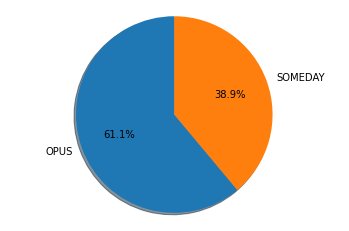

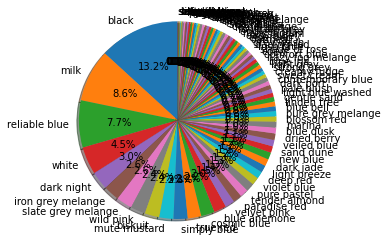

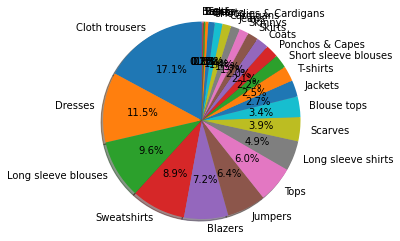

In [16]:
customer_id = 1006890
train_norm, test_norm = get_normilized_data()
trained_model = get_model('cosine', train_norm,'COUNT_FREQ')
recommentations_data = trained_model.recommend()
get_recommendation_for_user(customer_id, recommentations_data)


In [20]:
trained_model.recommend(['10000'])

CUSTOMER,SKU,score,rank
10000,226162328_1004,4.3439865112304685e-06,1
10000,220323811_6043,3.6513805389404296e-06,2
10000,225923960_4065,3.1650066375732423e-06,3
10000,225964002_10,3.114938735961914e-06,4
10000,225964002_6043,2.5045871734619142e-06,5
10000,607056677_900,2.2292137145996093e-06,6
10000,605806581_2047,1.8823146820068358e-06,7
10000,216204718_10,1.8513202667236327e-06,8
10000,221950650_10,1.7821788787841796e-06,9
10000,227564567_7304,1.7428398132324218e-06,10


## Run and evalute

### Compare and evaluate models with default `COUNT` as target

In [ ]:
train_norm, test_norm = get_normilized_data()
pop_norm = get_model('popularity', train_norm)
pop_norm.save('_output/models/pop_norm_count')
cos_norm = get_model('cosine', train_norm)
cos_norm.save('_output/models/cos_norm_count')
pear_norm = get_model('pearson', train_norm)
pear_norm.save('_output/models/pear_norm_count')

models_w_norm = [pop_norm, cos_norm, pear_norm]
names_w_norm = ['Popularity Model on COUNTS', 'Cosine Similarity on COUNTS', 'Pearson Similarity on COUNTS']
evaluation_result = evaluate(models_w_norm, names_w_norm, test_norm)


### Compare and evaluate models with 'COUNT_FREQ` as target

In [ ]:
pop_norm_freq = get_model('popularity', train_norm, target="COUNT_FREQ")
pop_norm_freq.save('_output/models/pop_norm_freq')
cos_norm_freq = get_model('cosine', train_norm, target="COUNT_FREQ")
cos_norm_freq.save('_output/models/cos_norm_freq')
pear_norm_freq = get_model('pearson', train_norm, target="COUNT_FREQ")
pear_norm_freq.save('_output/models/pear_norm_freq')

models_w_norm = [pop_norm_freq, cos_norm_freq, pear_norm_freq]
names_w_norm = ['Popularity Model on COUNTS_FREQ', 'Cosine Similarity on COUNTS_FREQ', 'Pearson Similarity on COUNTS_FREQ']
evaluation_result_freq = evaluate(models_w_norm, test_norm)


### Compare and evaluate `Cosine` similarity of `COUNT` and `COUNT_FREQ` targets

In [ ]:
models_w_norm = [cos_norm, cos_norm_freq]
names_w_norm = ['Cosine Similarity on COUNTS', 'Cosine Similarity on COUNTS_FREQ']
evaluation_result_freq = evaluate(models_w_norm, names_w_norm, test_norm)